In [1]:
# ============================================================================
# Cell 1: Evaluate DQN Model
# ============================================================================

import gymnasium as gym
import highway_env
import pandas as pd
import numpy as np
import os
from datetime import datetime
from stable_baselines3 import DQN
from env_config import get_env_config

AGENT_TYPE = "dqn"
AGENT_DIR = "dqn_agent"
N_EPISODES = 20
SAFE_TTC_THRESHOLD = 2.0

print(f"\n{'='*70}")
print(f"🚗 Evaluating DQN Agent")
print(f"{'='*70}\n")

# Load model
model = DQN.load(f"{AGENT_DIR}/model")

# Prepare folders
os.makedirs(f"{AGENT_DIR}/instant_runs", exist_ok=True)
os.makedirs(f"{AGENT_DIR}/summary", exist_ok=True)

# Create environment
env = gym.make("highway-v0", render_mode="human")
config = get_env_config()
env.unwrapped.config.update(config)

all_episode_stats = []

for ep in range(N_EPISODES):
    obs, info = env.reset()
    done = truncated = False
    
    ep_reward = 0
    ep_steps = 0
    ep_speed_sum = 0
    ep_lane_changes = 0
    
    previous_speed = 0.0
    previous_acc = 0.0
    jerk_values = []
    ttc_values = []
    
    ego_vehicle = env.unwrapped.vehicle
    previous_lane_index = ego_vehicle.lane_index[2] if ego_vehicle.lane_index is not None else None
    
    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        ep_reward += reward
        ep_steps += 1
        
        ego_vehicle = env.unwrapped.vehicle
        ego_pos = ego_vehicle.position
        ego_speed = ego_vehicle.speed
        ep_speed_sum += ego_speed
        
        # Jerk
        acc = ego_speed - previous_speed
        jerk = acc - previous_acc
        jerk_values.append(abs(jerk))
        previous_speed = ego_speed
        previous_acc = acc
        
        # TTC
        min_ttc = float("inf")
        for other in env.unwrapped.road.vehicles:
            if other is ego_vehicle:
                continue
            if ego_vehicle.lane_index is None or other.lane_index is None:
                continue
            if ego_vehicle.lane_index[2] != other.lane_index[2]:
                continue
            rel_x = other.position[0] - ego_pos[0]
            if rel_x <= 0:
                continue
            rel_v = ego_speed - other.speed
            if rel_v > 0.01:
                ttc = rel_x / rel_v
                min_ttc = min(min_ttc, ttc)
        if min_ttc != float("inf"):
            ttc_values.append(min_ttc)
        
        # Lane changes
        current_lane_index = ego_vehicle.lane_index[2] if ego_vehicle.lane_index is not None else None
        if previous_lane_index is not None and current_lane_index is not None and current_lane_index != previous_lane_index:
            ep_lane_changes += 1
        previous_lane_index = current_lane_index
    
    # Episode stats
    avg_speed = ep_speed_sum / (ep_steps + 1e-6)
    avg_jerk = np.mean(jerk_values) if jerk_values else 0
    max_jerk = np.max(jerk_values) if jerk_values else 0
    avg_ttc = np.mean(ttc_values) if ttc_values else -1
    min_ttc = np.min(ttc_values) if ttc_values else -1
    ttc_violations = sum(t < SAFE_TTC_THRESHOLD for t in ttc_values)
    ttc_violation_rate = ttc_violations / (ep_steps + 1e-6)
    
    all_episode_stats.append({
        "episode": ep+1,
        "total_reward": ep_reward,
        "steps": ep_steps,
        "avg_speed_ms": avg_speed,
        "lane_changes": ep_lane_changes,
        "avg_jerk": avg_jerk,
        "max_jerk": max_jerk,
        "avg_ttc": avg_ttc,
        "min_ttc": min_ttc,
        "ttc_violation_rate": ttc_violation_rate,
        "collision": info.get("crashed", False),
        "success": not info.get("crashed", False)
    })
    
    print(f"Episode {ep+1}/{N_EPISODES}: Reward={ep_reward:.2f}, Steps={ep_steps}, Crashed={info.get('crashed', False)}")

env.close()

# Save results
df_dqn = pd.DataFrame(all_episode_stats)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
df_dqn.to_csv(f"{AGENT_DIR}/instant_runs/run_{timestamp}.csv", index=False)
df_dqn.mean(numeric_only=True).to_frame("Value").to_csv(f"{AGENT_DIR}/summary/summary_{timestamp}.csv")

print(f"\n{'='*70}")
print(f"✅ DQN Evaluation Complete!")
print(f"📁 Results saved to: {AGENT_DIR}/instant_runs/run_{timestamp}.csv")
print(f"{'='*70}")

/home/jmffelisberto/Desktop/Modelling-Simulation/venv/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists



🚗 Evaluating DQN Agent

Episode 1/20: Reward=36.45, Steps=40, Crashed=False
Episode 2/20: Reward=21.45, Steps=24, Crashed=True
Episode 3/20: Reward=31.46, Steps=40, Crashed=False
Episode 4/20: Reward=34.07, Steps=40, Crashed=False
Episode 5/20: Reward=38.15, Steps=40, Crashed=False
Episode 6/20: Reward=7.88, Steps=9, Crashed=True
Episode 7/20: Reward=36.44, Steps=40, Crashed=False
Episode 8/20: Reward=8.22, Steps=10, Crashed=True
Episode 9/20: Reward=35.00, Steps=40, Crashed=False
Episode 10/20: Reward=38.27, Steps=40, Crashed=False
Episode 11/20: Reward=14.19, Steps=16, Crashed=True
Episode 12/20: Reward=12.32, Steps=14, Crashed=True
Episode 13/20: Reward=34.43, Steps=40, Crashed=False
Episode 14/20: Reward=36.58, Steps=40, Crashed=False
Episode 15/20: Reward=9.41, Steps=11, Crashed=True
Episode 16/20: Reward=3.79, Steps=5, Crashed=True
Episode 17/20: Reward=38.77, Steps=40, Crashed=False
Episode 18/20: Reward=13.15, Steps=15, Crashed=True
Episode 19/20: Reward=1.02, Steps=2, Crashed

In [2]:
# ============================================================================
# Cell 2: Evaluate PPO Model
# ============================================================================

import gymnasium as gym
import highway_env
import pandas as pd
import numpy as np
import os
from datetime import datetime
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from env_config import get_env_config
from reward_wrappers import LaneCenteringOvertakeReward

AGENT_TYPE = "ppo"
AGENT_DIR = "ppo_agent"
N_EPISODES = 20
SAFE_TTC_THRESHOLD = 2.0

print(f"\n{'='*70}")
print(f"🚗 Evaluating PPO Agent")
print(f"{'='*70}\n")

# Load model
model = PPO.load(f"{AGENT_DIR}/model")

# Prepare folders
os.makedirs(f"{AGENT_DIR}/instant_runs", exist_ok=True)
os.makedirs(f"{AGENT_DIR}/summary", exist_ok=True)

# Create environment (vectorized for PPO)
env = gym.make("highway-v0", render_mode="human")
config = get_env_config()
env.unwrapped.config.update(config)
vec_env = DummyVecEnv([lambda: env])
env = VecNormalize.load("ppo_agent/vec_normalize.pkl", vec_env)
env.training = False
env.norm_reward = False

eval_env = env.envs[0]
all_episode_stats = []

for ep in range(N_EPISODES):
    obs = env.reset()[0]
    done = False
    
    ep_reward = 0
    ep_steps = 0
    ep_speed_sum = 0
    ep_lane_changes = 0
    
    previous_speed = 0.0
    previous_acc = 0.0
    jerk_values = []
    ttc_values = []
    
    ego_vehicle = eval_env.unwrapped.vehicle
    previous_lane_index = ego_vehicle.lane_index[2] if ego_vehicle.lane_index is not None else None
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        action_arr = np.asarray(action)
        if action_arr.ndim == 0:
            action_arr = np.array([action_arr])
        obs, rewards, dones, infos = env.step(action_arr)
        reward = rewards[0]
        done = dones[0]
        info = infos[0]
        ep_reward += reward
        ep_steps += 1
        
        ego_vehicle = eval_env.unwrapped.vehicle
        ego_pos = ego_vehicle.position
        ego_speed = ego_vehicle.speed
        ep_speed_sum += ego_speed
        
        # Jerk
        acc = ego_speed - previous_speed
        jerk = acc - previous_acc
        jerk_values.append(abs(jerk))
        previous_speed = ego_speed
        previous_acc = acc
        
        # TTC
        min_ttc = float("inf")
        for other in eval_env.unwrapped.road.vehicles:
            if other is ego_vehicle:
                continue
            if ego_vehicle.lane_index is None or other.lane_index is None:
                continue
            if ego_vehicle.lane_index[2] != other.lane_index[2]:
                continue
            rel_x = other.position[0] - ego_pos[0]
            if rel_x <= 0:
                continue
            rel_v = ego_speed - other.speed
            if rel_v > 0.01:
                ttc = rel_x / rel_v
                min_ttc = min(min_ttc, ttc)
        if min_ttc != float("inf"):
            ttc_values.append(min_ttc)
        
        # Lane changes
        current_lane_index = ego_vehicle.lane_index[2] if ego_vehicle.lane_index is not None else None
        if previous_lane_index is not None and current_lane_index is not None and current_lane_index != previous_lane_index:
            ep_lane_changes += 1
        previous_lane_index = current_lane_index
    
    # Episode stats
    avg_speed = ep_speed_sum / (ep_steps + 1e-6)
    avg_jerk = np.mean(jerk_values) if jerk_values else 0
    max_jerk = np.max(jerk_values) if jerk_values else 0
    avg_ttc = np.mean(ttc_values) if ttc_values else -1
    min_ttc = np.min(ttc_values) if ttc_values else -1
    ttc_violations = sum(t < SAFE_TTC_THRESHOLD for t in ttc_values)
    ttc_violation_rate = ttc_violations / (ep_steps + 1e-6)
    
    all_episode_stats.append({
        "episode": ep+1,
        "total_reward": ep_reward,
        "steps": ep_steps,
        "avg_speed_ms": avg_speed,
        "lane_changes": ep_lane_changes,
        "avg_jerk": avg_jerk,
        "max_jerk": max_jerk,
        "avg_ttc": avg_ttc,
        "min_ttc": min_ttc,
        "ttc_violation_rate": ttc_violation_rate,
        "collision": info.get("crashed", False),
        "success": not info.get("crashed", False)
    })
    
    print(f"Episode {ep+1}/{N_EPISODES}: Reward={ep_reward:.2f}, Steps={ep_steps}, Crashed={info.get('crashed', False)}")

env.close()

# Save results
df_ppo = pd.DataFrame(all_episode_stats)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
df_ppo.to_csv(f"{AGENT_DIR}/instant_runs/run_{timestamp}.csv", index=False)
df_ppo.mean(numeric_only=True).to_frame("Value").to_csv(f"{AGENT_DIR}/summary/summary_{timestamp}.csv")

print(f"\n{'='*70}")
print(f"✅ PPO Evaluation Complete!")
print(f"📁 Results saved to: {AGENT_DIR}/instant_runs/run_{timestamp}.csv")
print(f"{'='*70}")


🚗 Evaluating PPO Agent



/home/jmffelisberto/Desktop/Modelling-Simulation/venv/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Episode 1/20: Reward=29.89, Steps=40, Crashed=False
Episode 2/20: Reward=30.43, Steps=40, Crashed=False
Episode 3/20: Reward=29.62, Steps=40, Crashed=False
Episode 4/20: Reward=30.05, Steps=40, Crashed=False
Episode 5/20: Reward=30.54, Steps=40, Crashed=False
Episode 6/20: Reward=30.23, Steps=40, Crashed=False
Episode 7/20: Reward=29.22, Steps=40, Crashed=False
Episode 8/20: Reward=28.74, Steps=40, Crashed=False
Episode 9/20: Reward=28.20, Steps=40, Crashed=False
Episode 10/20: Reward=29.36, Steps=40, Crashed=False
Episode 11/20: Reward=29.16, Steps=40, Crashed=False
Episode 12/20: Reward=30.29, Steps=40, Crashed=False
Episode 13/20: Reward=30.27, Steps=40, Crashed=False
Episode 14/20: Reward=29.36, Steps=40, Crashed=False
Episode 15/20: Reward=29.47, Steps=40, Crashed=False
Episode 16/20: Reward=29.96, Steps=40, Crashed=False
Episode 17/20: Reward=30.52, Steps=40, Crashed=False
Episode 18/20: Reward=29.36, Steps=40, Crashed=False
Episode 19/20: Reward=30.49, Steps=40, Crashed=False
Ep

In [3]:
# ============================================================================
# Cell 3: Evaluate SAC Model
# ============================================================================

import gymnasium as gym
import highway_env
import pandas as pd
import numpy as np
import os
from datetime import datetime
from stable_baselines3 import SAC
from env_config import get_continuous_env_config
from reward_wrappers import LaneCenteringOvertakeReward

AGENT_TYPE = "sac"
AGENT_DIR = "sac_agent"
N_EPISODES = 20
SAFE_TTC_THRESHOLD = 2.0

print(f"\n{'='*70}")
print(f"🚗 Evaluating SAC Agent")
print(f"{'='*70}\n")

# Load model
model = SAC.load(f"{AGENT_DIR}/model")

# Prepare folders
os.makedirs(f"{AGENT_DIR}/instant_runs", exist_ok=True)
os.makedirs(f"{AGENT_DIR}/summary", exist_ok=True)

# Create environment (continuous)
env = gym.make("highway-v0", render_mode="human")
config = get_continuous_env_config()
env.unwrapped.config.update(config)
env = LaneCenteringOvertakeReward(env)

all_episode_stats = []

for ep in range(N_EPISODES):
    obs, info = env.reset()
    done = truncated = False
    
    ep_reward = 0
    ep_steps = 0
    ep_speed_sum = 0
    ep_lane_changes = 0
    
    previous_speed = 0.0
    previous_acc = 0.0
    jerk_values = []
    ttc_values = []
    
    ego_vehicle = env.unwrapped.vehicle
    previous_lane_index = ego_vehicle.lane_index[2] if ego_vehicle.lane_index is not None else None
    
    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        ep_reward += reward
        ep_steps += 1
        
        ego_vehicle = env.unwrapped.vehicle
        ego_pos = ego_vehicle.position
        ego_speed = ego_vehicle.speed
        ep_speed_sum += ego_speed
        
        # Jerk
        acc = ego_speed - previous_speed
        jerk = acc - previous_acc
        jerk_values.append(abs(jerk))
        previous_speed = ego_speed
        previous_acc = acc
        
        # TTC
        min_ttc = float("inf")
        for other in env.unwrapped.road.vehicles:
            if other is ego_vehicle:
                continue
            if ego_vehicle.lane_index is None or other.lane_index is None:
                continue
            if ego_vehicle.lane_index[2] != other.lane_index[2]:
                continue
            rel_x = other.position[0] - ego_pos[0]
            if rel_x <= 0:
                continue
            rel_v = ego_speed - other.speed
            if rel_v > 0.01:
                ttc = rel_x / rel_v
                min_ttc = min(min_ttc, ttc)
        if min_ttc != float("inf"):
            ttc_values.append(min_ttc)
        
        # Lane changes
        current_lane_index = ego_vehicle.lane_index[2] if ego_vehicle.lane_index is not None else None
        if previous_lane_index is not None and current_lane_index is not None and current_lane_index != previous_lane_index:
            ep_lane_changes += 1
        previous_lane_index = current_lane_index
    
    # Episode stats
    avg_speed = ep_speed_sum / (ep_steps + 1e-6)
    avg_jerk = np.mean(jerk_values) if jerk_values else 0
    max_jerk = np.max(jerk_values) if jerk_values else 0
    avg_ttc = np.mean(ttc_values) if ttc_values else -1
    min_ttc = np.min(ttc_values) if ttc_values else -1
    ttc_violations = sum(t < SAFE_TTC_THRESHOLD for t in ttc_values)
    ttc_violation_rate = ttc_violations / (ep_steps + 1e-6)
    
    all_episode_stats.append({
        "episode": ep+1,
        "total_reward": ep_reward,
        "steps": ep_steps,
        "avg_speed_ms": avg_speed,
        "lane_changes": ep_lane_changes,
        "avg_jerk": avg_jerk,
        "max_jerk": max_jerk,
        "avg_ttc": avg_ttc,
        "min_ttc": min_ttc,
        "ttc_violation_rate": ttc_violation_rate,
        "collision": info.get("crashed", False),
        "success": not info.get("crashed", False)
    })
    
    print(f"Episode {ep+1}/{N_EPISODES}: Reward={ep_reward:.2f}, Steps={ep_steps}, Crashed={info.get('crashed', False)}")

env.close()

# Save results
df_sac = pd.DataFrame(all_episode_stats)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
df_sac.to_csv(f"{AGENT_DIR}/instant_runs/run_{timestamp}.csv", index=False)
df_sac.mean(numeric_only=True).to_frame("Value").to_csv(f"{AGENT_DIR}/summary/summary_{timestamp}.csv")

print(f"\n{'='*70}")
print(f"✅ SAC Evaluation Complete!")
print(f"📁 Results saved to: {AGENT_DIR}/instant_runs/run_{timestamp}.csv")
print(f"{'='*70}")


🚗 Evaluating SAC Agent

Episode 1/20: Reward=15.86, Steps=43, Crashed=True
Episode 2/20: Reward=39.26, Steps=80, Crashed=False
Episode 3/20: Reward=42.24, Steps=80, Crashed=False
Episode 4/20: Reward=37.54, Steps=77, Crashed=False
Episode 5/20: Reward=41.01, Steps=80, Crashed=False
Episode 6/20: Reward=41.96, Steps=80, Crashed=False
Episode 7/20: Reward=-0.45, Steps=12, Crashed=True
Episode 8/20: Reward=31.19, Steps=67, Crashed=False
Episode 9/20: Reward=37.96, Steps=80, Crashed=False
Episode 10/20: Reward=30.15, Steps=68, Crashed=True
Episode 11/20: Reward=6.80, Steps=27, Crashed=True
Episode 12/20: Reward=38.83, Steps=80, Crashed=False
Episode 13/20: Reward=39.44, Steps=80, Crashed=False
Episode 14/20: Reward=40.53, Steps=80, Crashed=False
Episode 15/20: Reward=35.66, Steps=71, Crashed=False
Episode 16/20: Reward=40.88, Steps=80, Crashed=False
Episode 17/20: Reward=37.64, Steps=80, Crashed=False
Episode 18/20: Reward=25.22, Steps=69, Crashed=True
Episode 19/20: Reward=40.76, Steps=8

In [4]:
# ============================================================================
# Cell 4: Evaluate TD3 Model
# ============================================================================

import gymnasium as gym
import highway_env
import pandas as pd
import numpy as np
import os
from datetime import datetime
from stable_baselines3 import TD3
from env_config import get_continuous_env_config
from reward_wrappers import LaneCenteringOvertakeReward

AGENT_TYPE = "td3"
AGENT_DIR = "td3_agent"
N_EPISODES = 20
SAFE_TTC_THRESHOLD = 2.0

print(f"\n{'='*70}")
print(f"🚗 Evaluating TD3 Agent")
print(f"{'='*70}\n")

# Load model
model = TD3.load(f"{AGENT_DIR}/model")

# Prepare folders
os.makedirs(f"{AGENT_DIR}/instant_runs", exist_ok=True)
os.makedirs(f"{AGENT_DIR}/summary", exist_ok=True)

# Create environment (continuous)
env = gym.make("highway-v0", render_mode="human")
config = get_continuous_env_config()
env.unwrapped.config.update(config)
env = LaneCenteringOvertakeReward(env)

all_episode_stats = []

for ep in range(N_EPISODES):
    obs, info = env.reset()
    done = truncated = False
    
    ep_reward = 0
    ep_steps = 0
    ep_speed_sum = 0
    ep_lane_changes = 0
    
    previous_speed = 0.0
    previous_acc = 0.0
    jerk_values = []
    ttc_values = []
    
    ego_vehicle = env.unwrapped.vehicle
    previous_lane_index = ego_vehicle.lane_index[2] if ego_vehicle.lane_index is not None else None
    
    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        ep_reward += reward
        ep_steps += 1
        
        ego_vehicle = env.unwrapped.vehicle
        ego_pos = ego_vehicle.position
        ego_speed = ego_vehicle.speed
        ep_speed_sum += ego_speed
        
        # Jerk
        acc = ego_speed - previous_speed
        jerk = acc - previous_acc
        jerk_values.append(abs(jerk))
        previous_speed = ego_speed
        previous_acc = acc
        
        # TTC
        min_ttc = float("inf")
        for other in env.unwrapped.road.vehicles:
            if other is ego_vehicle:
                continue
            if ego_vehicle.lane_index is None or other.lane_index is None:
                continue
            if ego_vehicle.lane_index[2] != other.lane_index[2]:
                continue
            rel_x = other.position[0] - ego_pos[0]
            if rel_x <= 0:
                continue
            rel_v = ego_speed - other.speed
            if rel_v > 0.01:
                ttc = rel_x / rel_v
                min_ttc = min(min_ttc, ttc)
        if min_ttc != float("inf"):
            ttc_values.append(min_ttc)
        
        # Lane changes
        current_lane_index = ego_vehicle.lane_index[2] if ego_vehicle.lane_index is not None else None
        if previous_lane_index is not None and current_lane_index is not None and current_lane_index != previous_lane_index:
            ep_lane_changes += 1
        previous_lane_index = current_lane_index
    
    # Episode stats
    avg_speed = ep_speed_sum / (ep_steps + 1e-6)
    avg_jerk = np.mean(jerk_values) if jerk_values else 0
    max_jerk = np.max(jerk_values) if jerk_values else 0
    avg_ttc = np.mean(ttc_values) if ttc_values else -1
    min_ttc = np.min(ttc_values) if ttc_values else -1
    ttc_violations = sum(t < SAFE_TTC_THRESHOLD for t in ttc_values)
    ttc_violation_rate = ttc_violations / (ep_steps + 1e-6)
    
    all_episode_stats.append({
        "episode": ep+1,
        "total_reward": ep_reward,
        "steps": ep_steps,
        "avg_speed_ms": avg_speed,
        "lane_changes": ep_lane_changes,
        "avg_jerk": avg_jerk,
        "max_jerk": max_jerk,
        "avg_ttc": avg_ttc,
        "min_ttc": min_ttc,
        "ttc_violation_rate": ttc_violation_rate,
        "collision": info.get("crashed", False),
        "success": not info.get("crashed", False)
    })
    
    print(f"Episode {ep+1}/{N_EPISODES}: Reward={ep_reward:.2f}, Steps={ep_steps}, Crashed={info.get('crashed', False)}")

env.close()

# Save results
df_td3 = pd.DataFrame(all_episode_stats)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
df_td3.to_csv(f"{AGENT_DIR}/instant_runs/run_{timestamp}.csv", index=False)
df_td3.mean(numeric_only=True).to_frame("Value").to_csv(f"{AGENT_DIR}/summary/summary_{timestamp}.csv")

print(f"\n{'='*70}")
print(f"✅ TD3 Evaluation Complete!")
print(f"📁 Results saved to: {AGENT_DIR}/instant_runs/run_{timestamp}.csv")
print(f"{'='*70}")


🚗 Evaluating TD3 Agent

Episode 1/20: Reward=38.65, Steps=80, Crashed=False
Episode 2/20: Reward=40.20, Steps=80, Crashed=False
Episode 3/20: Reward=27.43, Steps=64, Crashed=False
Episode 4/20: Reward=1.14, Steps=17, Crashed=True
Episode 5/20: Reward=39.64, Steps=80, Crashed=False
Episode 6/20: Reward=38.60, Steps=80, Crashed=False
Episode 7/20: Reward=37.54, Steps=80, Crashed=False
Episode 8/20: Reward=23.30, Steps=54, Crashed=False
Episode 9/20: Reward=21.09, Steps=43, Crashed=False
Episode 10/20: Reward=15.94, Steps=38, Crashed=False
Episode 11/20: Reward=37.75, Steps=79, Crashed=False
Episode 12/20: Reward=39.80, Steps=80, Crashed=False
Episode 13/20: Reward=37.38, Steps=78, Crashed=False
Episode 14/20: Reward=7.31, Steps=18, Crashed=False
Episode 15/20: Reward=22.34, Steps=48, Crashed=False
Episode 16/20: Reward=40.41, Steps=80, Crashed=False
Episode 17/20: Reward=42.34, Steps=80, Crashed=False
Episode 18/20: Reward=8.40, Steps=20, Crashed=False
Episode 19/20: Reward=29.94, Steps


🏆 COMPREHENSIVE MODEL COMPARISON

✅ Loading DQN: summary_20260108_155818.csv

✅ Loading PPO: summary_20260108_160001.csv

✅ Loading SAC: summary_20260108_160131.csv

✅ Loading TD3: summary_20260108_160247.csv

📊 PERFORMANCE INDICATORS

Model  GPS  Safety (SI)  Efficiency (EI)  Comfort (CI)  Compliance (RCI)
  DQN 0.39          0.6              0.0           1.0               0.0
  PPO 0.39          0.6              0.0           1.0               0.0
  SAC 0.39          0.6              0.0           1.0               0.0
  TD3 0.39          0.6              0.0           1.0               0.0

📈 RAW METRICS

Model  Collision Rate  Success Rate  Avg Speed (m/s)  Avg TTC (s)  Avg Jerk  Lane Changes
  DQN             0.0           0.0              0.0           -1       0.0           0.0
  PPO             0.0           0.0              0.0           -1       0.0           0.0
  SAC             0.0           0.0              0.0           -1       0.0           0.0
  TD3             0.0 

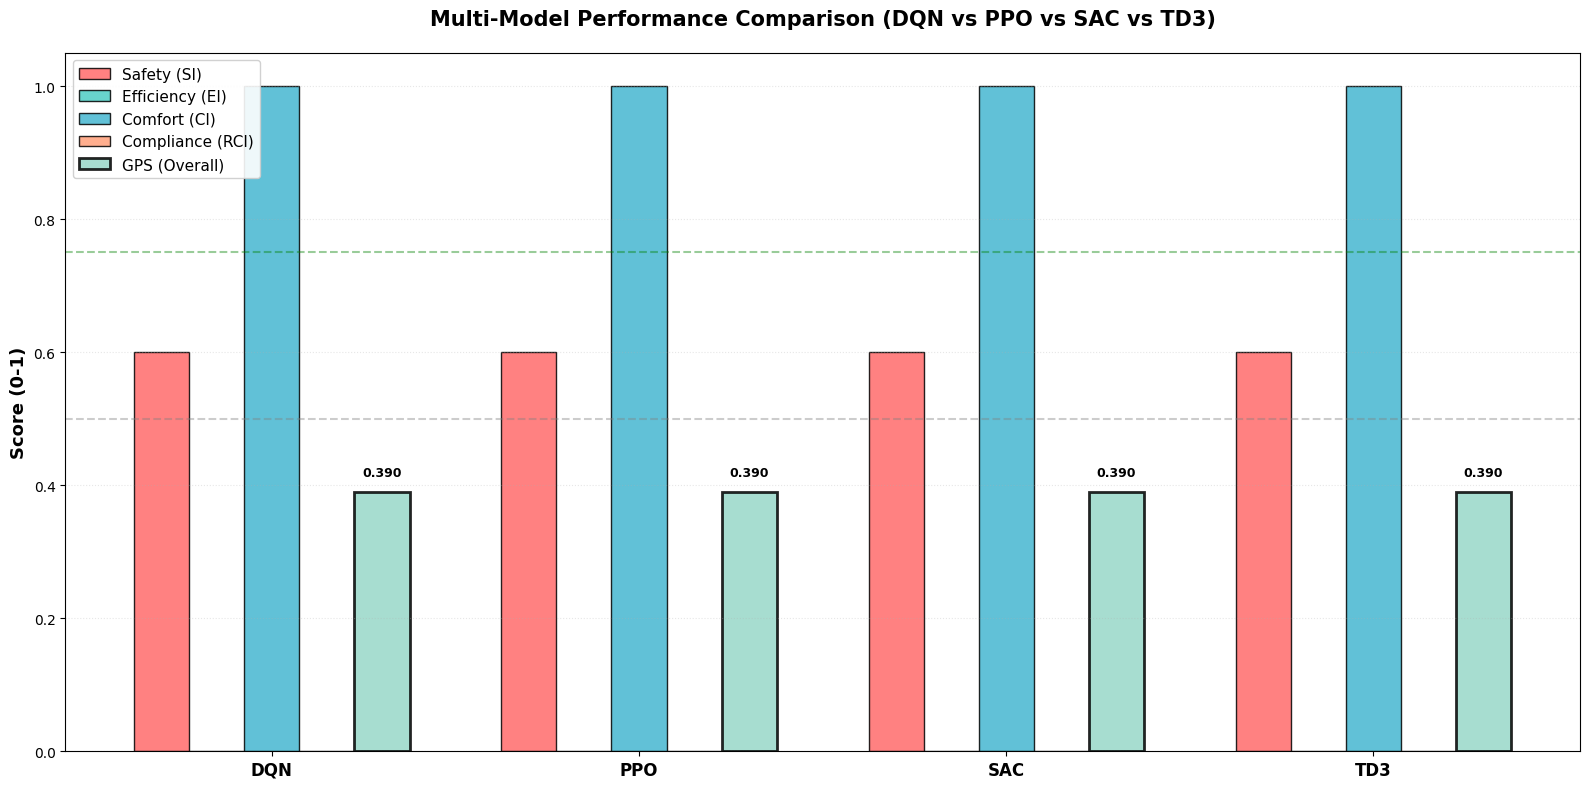


📊 Visualization complete!



In [ ]:
# ============================================================================
# Cell 5: Comprehensive Model Comparison
# ============================================================================

import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime
import matplotlib.pyplot as plt

# Constants
SPEED_LIMIT_MS = 32.0
SAFE_TTC_THRESHOLD = 2.0
MAX_EXPECTED_JERK = 10.0
MAX_EXPECTED_LANE_CHANGES = 20.0

# Models to compare
MODELS = [
    ("DQN", "dqn_agent/summary/summary_*.csv"),
    ("PPO", "ppo_agent/summary/summary_*.csv"),
    ("SAC", "sac_agent/summary/summary_*.csv"),
    ("TD3", "td3_agent/summary/summary_*.csv"),
]

print("\n" + "="*80)
print("🏆 COMPREHENSIVE MODEL COMPARISON")
print("="*80)

comparison_results = []

for model_name, csv_pattern in MODELS:
    csv_files = glob.glob(csv_pattern)
    
    if not csv_files:
        print(f"\n⚠️  No data for {model_name}")
        continue
    
    # Get most recent results
    latest_csv = max(csv_files, key=os.path.getctime)
    print(f"\n✅ Loading {model_name}: {os.path.basename(latest_csv)}")
    
    # Load metrics (first column is metric names as index, second column is values)
    model_df = pd.read_csv(latest_csv, index_col=0)
    model_metrics = model_df['Value'].to_dict()
    
    def get_val(key, default=0.0):
        return model_metrics.get(key, default)
    
    # Calculate Safety Index
    collision_rate = get_val("collision")
    avg_ttc = get_val("avg_ttc", -1)
    ttc_violation_rate = get_val("ttc_violation_rate")
    ttc_normalized = min(avg_ttc / SAFE_TTC_THRESHOLD, 1.0) if avg_ttc > 0 else 0.0
    SI = 0.4 * (1 - collision_rate) + 0.4 * ttc_normalized + 0.2 * (1 - ttc_violation_rate)
    
    # Calculate Efficiency Index
    avg_speed = get_val("avg_speed_ms")
    success_rate = get_val("success")
    speed_ratio = min(avg_speed / SPEED_LIMIT_MS, 1.0)
    EI = 0.5 * speed_ratio + 0.5 * success_rate
    
    # Calculate Comfort Index
    jerk = get_val("avg_jerk")
    lane_changes = get_val("lane_changes")
    jerk_norm = min(jerk / MAX_EXPECTED_JERK, 1.0)
    lane_norm = min(lane_changes / MAX_EXPECTED_LANE_CHANGES, 1.0)
    discomfort = 0.6 * jerk_norm + 0.4 * lane_norm
    CI = max(1 - discomfort, 0.0)
    
    # Calculate Rule Compliance Index
    RCI = min(avg_speed / SPEED_LIMIT_MS, 1.0)
    
    # Calculate Global Performance Score
    GPS = 0.40 * SI + 0.30 * EI + 0.15 * CI + 0.15 * RCI
    
    comparison_results.append({
        'Model': model_name,
        'GPS': GPS,
        'Safety (SI)': SI,
        'Efficiency (EI)': EI,
        'Comfort (CI)': CI,
        'Compliance (RCI)': RCI,
        'Collision Rate': collision_rate,
        'Success Rate': success_rate,
        'Avg Speed (m/s)': avg_speed,
        'Avg TTC (s)': avg_ttc,
        'Avg Jerk': jerk,
        'Lane Changes': lane_changes,
        'Avg Reward': get_val("total_reward")
    })

if comparison_results:
    comp_df = pd.DataFrame(comparison_results)
    
    # Display comprehensive table
    print("\n" + "="*80)
    print("📊 PERFORMANCE INDICATORS")
    print("="*80 + "\n")
    print(comp_df[['Model', 'GPS', 'Safety (SI)', 'Efficiency (EI)', 
                   'Comfort (CI)', 'Compliance (RCI)']].to_string(index=False))
    
    print("\n" + "="*80)
    print("📈 RAW METRICS")
    print("="*80 + "\n")
    print(comp_df[['Model', 'Collision Rate', 'Success Rate', 'Avg Speed (m/s)', 
                   'Avg TTC (s)', 'Avg Jerk', 'Lane Changes']].to_string(index=False))
    
    print("\n" + "="*80)
    print("🥇 WINNERS BY CATEGORY")
    print("="*80)
    
    categories = {
        'Overall Performance (GPS)': 'GPS',
        'Safety': 'Safety (SI)',
        'Efficiency': 'Efficiency (EI)',
        'Comfort': 'Comfort (CI)',
        'Rule Compliance': 'Compliance (RCI)'
    }
    
    for category, metric in categories.items():
        winner = comp_df.loc[comp_df[metric].idxmax()]
        print(f"   {category:<30}: {winner['Model']:<6} (Score: {winner[metric]:.4f})")
    
    print("="*80)
    
    # Save comparison
    os.makedirs("model_comparison", exist_ok=True)
    output_path = f"model_comparison/comparison_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    comp_df.to_csv(output_path, index=False)
    print(f"\n💾 Comparison saved: {output_path}")
    
    # Visualization
    models = comp_df['Model'].tolist()
    x = np.arange(len(models))
    width = 0.15
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    ax.bar(x - 2*width, comp_df['Safety (SI)'], width, label='Safety (SI)', 
           color='#FF6B6B', alpha=0.85, edgecolor='black', linewidth=1)
    ax.bar(x - width, comp_df['Efficiency (EI)'], width, label='Efficiency (EI)', 
           color='#4ECDC4', alpha=0.85, edgecolor='black', linewidth=1)
    ax.bar(x, comp_df['Comfort (CI)'], width, label='Comfort (CI)', 
           color='#45B7D1', alpha=0.85, edgecolor='black', linewidth=1)
    ax.bar(x + width, comp_df['Compliance (RCI)'], width, label='Compliance (RCI)', 
           color='#FFA07A', alpha=0.85, edgecolor='black', linewidth=1)
    ax.bar(x + 2*width, comp_df['GPS'], width, label='GPS (Overall)', 
           color='#98D8C8', alpha=0.85, edgecolor='black', linewidth=2)
    
    # Add value labels on bars
    for i, model in enumerate(models):
        ax.text(i + 2*width, comp_df.loc[i, 'GPS'] + 0.02, 
                f"{comp_df.loc[i, 'GPS']:.3f}", 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_ylabel('Score (0-1)', fontsize=13, fontweight='bold')
    ax.set_title('Multi-Model Performance Comparison (DQN vs PPO vs SAC vs TD3)', 
                 fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=12, fontweight='bold')
    ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.4, linewidth=1.5, label='Acceptable (0.5)')
    ax.axhline(y=0.75, color='green', linestyle='--', alpha=0.4, linewidth=1.5, label='Good (0.75)')
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', alpha=0.3, linestyle=':')
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Visualization complete!")
    print("\n" + "="*80)

else:
    print("\n❌ No models found. Run cells 1-4 first to evaluate all models!")